<a href="https://colab.research.google.com/github/mohmmadhadi/MarketingLab/blob/main/Marketing_Atribution_Markov_Chain_Mohammadhadi_Shahhosseini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [1]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 47.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preprocessing

In [7]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/marketing_attribution.csv')

<ipython-input-7-09fb015e3c88>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/marketing_attribution.csv')


In [8]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/marketing_attribution.csv')

<ipython-input-8-65e08bd7cf4f>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/marketing_attribution.csv')


##Data Preprocessing for last click model

In [6]:
# Handling missing values
df['transactionRevenue'].fillna(0, inplace=True)
df['transactionId'].fillna("", inplace=True)

# Converting visitStartTime to datetime
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

In [7]:
# Adding a conversion column to indicate whether there was a conversion or not
df['conversion'] = df['transactionRevenue'].apply(lambda x: True if pd.notna(x) and x > 0 else False)

# Filter conversions
conversions = df[df['conversion'] == True]

In [8]:
# Function to find the last click within 30 days before conversion
def get_last_click_within_window(fullVisitorId, conversion_time, df, window=30):
    window_start = conversion_time - timedelta(days=window)
    user_data = df[(df['fullVisitorId'] == fullVisitorId) &
                   (df['visitStartTime'] >= window_start) &
                   (df['visitStartTime'] <= conversion_time)]
    if not user_data.empty:
        last_click = user_data.loc[user_data['visitStartTime'].idxmax()]
        return last_click
    else:
        return None

In [9]:
# Create a list to store attribution results
attribution_results = []

In [10]:
# Loop through each conversion to find the last click within the attribution window
for _, row in conversions.iterrows():
    fullVisitorId = row['fullVisitorId']
    conversion_time = row['visitStartTime']
    last_click = get_last_click_within_window(fullVisitorId, conversion_time, df)
    if last_click is not None:
        attribution_results.append({
            'fullVisitorId': fullVisitorId,
            'conversion_time': conversion_time,
            'last_channel': last_click['channelGrouping']
        })

In [11]:
# Convert the attribution results to a DataFrame
attribution_df = pd.DataFrame(attribution_results)
print(attribution_df.head(10))

         fullVisitorId     conversion_time    last_channel
0   376313822453352161 2016-12-18 01:37:29  Organic Search
1  5216295436197840308 2016-12-17 18:37:48          Direct
2   896420018503205883 2016-12-17 22:00:28        Referral
3  1995748726207840322 2016-12-18 03:29:51        Referral
4  8402574004959447870 2016-12-17 17:17:59          Direct
5  6224639817725111721 2016-12-18 04:15:47     Paid Search
6   940775638196153770 2016-12-17 18:02:50          Direct
7  8415446163496582729 2016-12-17 19:31:41        Referral
8    41955139058139143 2016-12-17 21:28:15        Referral
9   835945267501881844 2016-12-17 23:25:46          Direct


In [13]:
file_path = '/content/drive/My Drive/LC_attribution_df.csv'
attribution_df.to_csv(file_path, index=False)

In [4]:
attribution_df = pd.read_csv('/content/drive/My Drive/LC_attribution_df.csv')

In [5]:
# Aggregate the results to count the number of conversions attributed to each channel
last_click_attribution = attribution_df['last_channel'].value_counts().reset_index()
last_click_attribution.columns = ['channel', 'conversions']
print(last_click_attribution)

KeyError: 'last_channel'

#Last Click Attribution Model

In [14]:
# Calculate total number of visits per channel
total_visits_per_channel = df.groupby('channelGrouping').size().reset_index(name='total_visits')

# Merge conversion counts with visit counts
conversion_summary = pd.merge(last_click_attribution, total_visits_per_channel, left_on='channel', right_on='channelGrouping', how='left')

# Calculate conversion rate per channel
conversion_summary['conversion_rate'] = (conversion_summary['conversions'] / conversion_summary['total_visits']) * 100

# Calculate contribution to overall conversions
total_conversions = conversion_summary['conversions'].sum()
conversion_summary['conversion_contribution'] = (conversion_summary['conversions'] / total_conversions) * 100

# Final sorted summary
conversion_summary = conversion_summary.sort_values(by='conversion_rate', ascending=False)

# Display the final summary table
print(conversion_summary[['channel', 'conversions', 'total_visits', 'conversion_rate', 'conversion_contribution']])

          channel  conversions  total_visits  conversion_rate  \
0        Referral         5311        104838         5.065911   
4         Display          142          6262         2.267646   
3     Paid Search          468         25326         1.847903   
2          Direct         2042        143026         1.427712   
1  Organic Search         3438        381561         0.901035   
7         (Other)            1           120         0.833333   
6      Affiliates            9         16403         0.054868   
5          Social          104        226117         0.045994   

   conversion_contribution  
0                46.122449  
4                 1.233174  
3                 4.064264  
2                17.733391  
1                29.856709  
7                 0.008684  
6                 0.078159  
5                 0.903170  


In [15]:
conversion_summary = conversion_summary.sort_values(by = 'conversion_contribution', ascending=False)

##Visualization

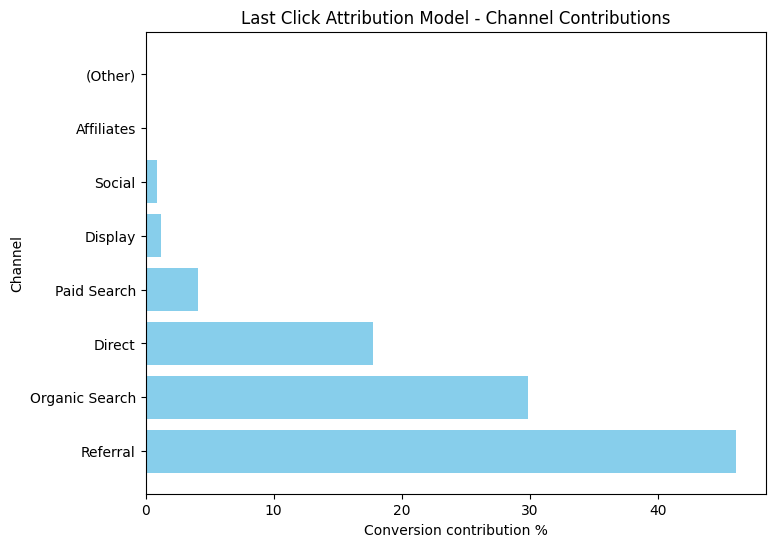

In [16]:
plt.figure(figsize=(8, 6))
plt.barh(conversion_summary['channelGrouping'], conversion_summary['conversion_contribution'], color='skyblue')
plt.title('Last Click Attribution Model - Channel Contributions')
plt.xlabel('Conversion contribution %')
plt.ylabel('Channel')
plt.show()

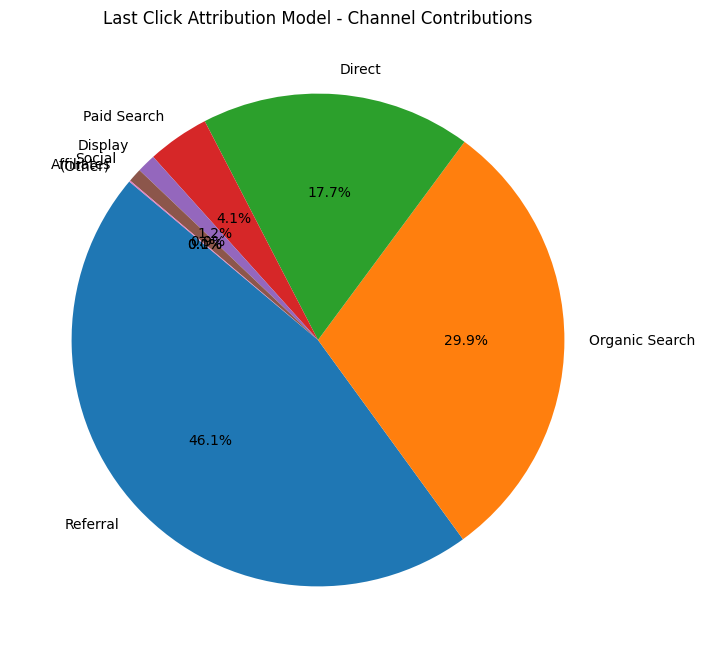

In [17]:
plt.figure(figsize=(8, 8))
plt.pie(conversion_summary['conversion_contribution'], labels=conversion_summary['channelGrouping'], autopct="%1.1f%%", startangle=140)
plt.title('Last Click Attribution Model - Channel Contributions')
plt.show()

#Data Driven Attribution Model (Markov Chains)

##Model

In [9]:
# Step 1: Preparation
df = data.copy()

# Handling missing values
df['transactionRevenue'].fillna(0, inplace=True)
df['transactionId'].fillna("", inplace=True)


In [10]:
# Converting visitStartTime to datetime
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

# Adding a conversion column to indicate whether there was a conversion or not
df['conversion'] = df['transactionRevenue'].apply(lambda x: True if pd.notna(x) and x > 0 else False)

In [11]:
# Define the attribution window
attribution_window = 30

def apply_attribution_window(data, window_days=30):
    data['conversion_date'] = data.groupby('fullVisitorId')['visitStartTime'].transform(lambda x: x.max())
    data['within_window'] = (data['conversion_date'] - data['visitStartTime']) <= timedelta(days=window_days)
    return data[data['within_window']]


In [12]:
data_within_window = apply_attribution_window(df)

In [13]:
# Step 2: Create paths for each visitor
def get_user_paths(df):
    paths = df.sort_values('visitStartTime').groupby('fullVisitorId')['channelGrouping'].apply(lambda x: ' > '.join(x))
    return paths

In [14]:
# Create paths
user_paths = get_user_paths(df)

In [15]:
# Adding start and conversion state to the path
user_paths = 'Start > ' + user_paths
conversions = df[df['conversion'] == True]
conversions_paths = conversions.groupby('fullVisitorId').apply(lambda x: x['channelGrouping'].values[-1])
user_paths[conversions_paths.index] += ' > Conversion'
user_paths = user_paths.apply(lambda x: x + ' > No Conversion' if not x.endswith('Conversion') else x)

In [16]:
# Step 3: Create Transition Matrix
def create_transition_matrix(paths):
    transitions = {}
    for path in paths:
        steps = path.split(' > ')
        for i in range(len(steps) - 1):
            if steps[i] not in transitions:
                transitions[steps[i]] = {}
            if steps[i+1] not in transitions[steps[i]]:
                transitions[steps[i]][steps[i+1]] = 0
            transitions[steps[i]][steps[i+1]] += 1
    return transitions

In [17]:
transitions = create_transition_matrix(user_paths)

In [18]:
# Convert to DataFrame
channels = list(set([step for path in user_paths for step in path.split(' > ')]))  # Convert set to list

# Ensure the channels list includes all expected states
expected_states = ['Start', 'Conversion', 'No Conversion']
channels = list(set(channels + expected_states))

# Create the transition matrix DataFrame
transition_df = pd.DataFrame(0, index=channels, columns=channels)
for from_channel in transitions:
    for to_channel in transitions[from_channel]:
        transition_df.loc[from_channel, to_channel] = transitions[from_channel][to_channel]


In [19]:
# Normalize the matrix
transition_df = transition_df.div(transition_df.sum(axis=1), axis=0).fillna(0)

In [29]:
file_path2 = '/content/drive/My Drive/transition_df.csv'
transition_df.to_csv(file_path, index=False)

In [6]:
transition_df = pd.read_csv('/content/drive/My Drive/transition_df.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/transition_df.csv'

In [ ]:
transition_df

,Organic Search,No Conversion,Paid Search,Referral,Direct,Affiliates,Social,(Other),Conversion,Start,Display
Organic Search,0.163054,0.808445,0.004731,0.009330,0.000446,0.001216,0.001911,0.000081,0.008410,0.0,0.002377
No Conversion,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Paid Search,0.086907,0.645542,0.232607,0.006397,0.000908,0.000276,0.001264,0.000158,0.017610,0.0,0.008331
Referral,0.020517,0.602806,0.001641,0.320742,0.001288,0.001698,0.003243,0.000200,0.045165,0.0,0.002699
Direct,0.017039,0.728784,0.002363,0.019052,0.214828,0.001573,0.003027,0.000049,0.011606,0.0,0.001678
Affiliates,0.017802,0.781686,0.000914,0.030970,0.000305,0.166372,0.001219,0.000061,0.000610,0.0,0.000061
Social,0.002680,0.942755,0.000429,0.001411,0.000066,0.000084,0.051947,0.000004,0.000433,0.0,0.000190
(Other),0.050000,0.508333,0.033333,0.100000,0.000000,0.033333,0.008333,0.191667,0.016667,0.0,0.058333
Conversion,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Start,0.425121,0.000000,0.023116,0.087050,0.152898,0.017446,0.290658,0.000037,0.000000,0.0,0.003674


In [20]:
# Step 4: Calculate Removal Effects
def removal_effect(transition_matrix, channel_to_remove):
    modified_matrix = transition_matrix.copy()
    modified_matrix.loc[channel_to_remove] = 0
    modified_matrix = modified_matrix.div(modified_matrix.sum(axis=1), axis=0).fillna(0)
    return modified_matrix

def absorbing_probabilities(transition_matrix, start_state='Start', end_state='Conversion'):
    Q = transition_matrix.loc[transition_matrix.index.difference([end_state, 'No Conversion']), transition_matrix.columns.difference([end_state, 'No Conversion'])]
    R = transition_matrix.loc[transition_matrix.index.difference([end_state, 'No Conversion']), [end_state]]
    I = np.eye(len(Q))
    N = np.linalg.inv(I - Q)
    B = np.dot(N, R)
    return B



In [21]:
original_probs = absorbing_probabilities(transition_df)

In [22]:
# Calculate the effect of removing each channel
removal_effects = {}
for channel in channels:
    if channel not in ['Start', 'Conversion', 'No Conversion']:
        modified_matrix = removal_effect(transition_df, channel)
        modified_probs = absorbing_probabilities(modified_matrix)
        removal_effects[channel] = (original_probs - modified_probs).sum()

In [23]:
# Normalize the removal effects to get the attribution weights
total_effect = sum(removal_effects.values())
markov_attribution = {k: v / total_effect for k, v in removal_effects.items()}


In [24]:
# Step 5: Compare Models
# Convert markov_attribution to DataFrame
markov_attribution_df = pd.DataFrame(list(markov_attribution.items()), columns=['channel', 'attribution'])

In [25]:
markov_attribution_df['DDA Conversion Contribution'] = markov_attribution_df['attribution'] * 100

In [26]:
markov = markov_attribution_df.drop('attribution', axis = 1)

In [27]:
markov = markov.sort_values(by= 'DDA Conversion Contribution', ascending = False)

In [38]:
# Last Click Attribution
last_click_attribution = attribution_df['last_channel'].value_counts().reset_index()
last_click_attribution.columns = ['channel', 'conversions']

# Merge markov and last click attribution for comparison
comparison_df = last_click_attribution.merge(markov, on='channel', how='outer').fillna(0)

# Final comparison summary
comparison_summary = pd.merge(conversion_summary, markov, left_on='channel', right_on='channel', how='left')
comparison_summary = comparison_summary[['channel', 'conversions', 'total_visits', 'conversion_rate', 'conversion_contribution', 'DDA Conversion Contribution']]

In [39]:
comparison_summary = comparison_summary.rename(columns = {'conversion_contribution': 'LC Conversion Contribution'})

##Visualization

Transition Matrix Heatmap

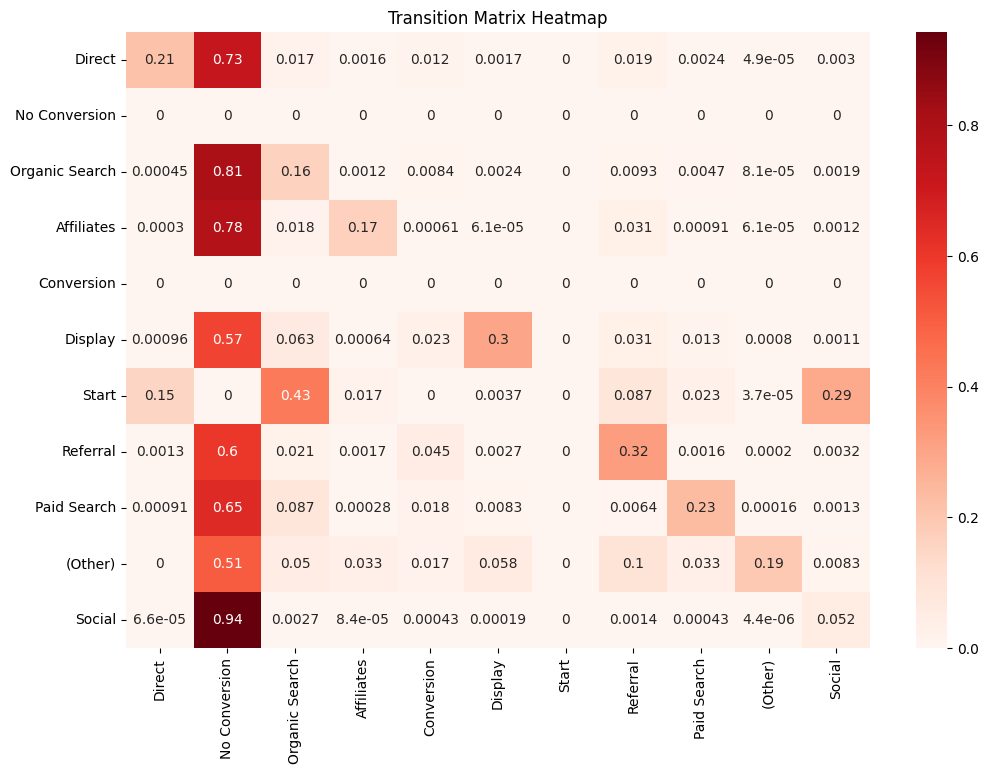

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(transition_df, annot=True, cmap='Reds')
plt.title('Transition Matrix Heatmap')
plt.show()

Sankey Diagram

In [28]:
# Prepare data for Sankey plot
def prepare_sankey_data(transition_df):
    sources = []
    targets = []
    values = []
    for from_channel in transition_df.index:
        for to_channel in transition_df.columns:
            if transition_df.loc[from_channel, to_channel] > 0:
                sources.append(from_channel)
                targets.append(to_channel)
                values.append(transition_df.loc[from_channel, to_channel])

    # Create a list of unique channels for the Sankey plot
    all_channels = list(set(sources + targets))

    # Map channels to indices
    channel_indices = {channel: idx for idx, channel in enumerate(all_channels)}

    # Convert channel names to indices for Sankey plot
    sources_indices = [channel_indices[channel] for channel in sources]
    targets_indices = [channel_indices[channel] for channel in targets]

    return sources_indices, targets_indices, values, all_channels

# Prepare data for removal effect and conversion contribution
def prepare_removal_effect_data(markov_attribution_df):
    removal_effect_data = markov_attribution_df.sort_values(by='DDA Conversion Contribution', ascending=False)
    return removal_effect_data

sources_indices, targets_indices, values, all_channels = prepare_sankey_data(transition_df)
removal_effect_data = prepare_removal_effect_data(markov_attribution_df)

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Markov Chain Attribution Model"),

    # Radio buttons to select view
    html.Label("Select View:"),
    dcc.RadioItems(
        id='view-selector',
        options=[
            {'label': 'Sankey Plot', 'value': 'sankey'},
            {'label': 'Conversion Contribution', 'value': 'contribution'}
        ],
        value='sankey',  # Default value
        labelStyle={'display': 'inline-block'}
    ),

    # Dropdown to filter channels (only for Sankey plot)
    html.Label("Select Channels to Display:", id='channel-dropdown-label'),
    dcc.Dropdown(
        id='channel-dropdown',
        options=[{'label': channel, 'value': channel} for channel in all_channels],
        value=all_channels,  # Default value showing all channels
        multi=True
    ),

    dcc.Graph(id='visualization')
])

@app.callback(
    Output('channel-dropdown-label', 'style'),
    Output('channel-dropdown', 'style'),
    Input('view-selector', 'value')
)
def toggle_channel_dropdown(selected_view):
    if selected_view == 'sankey':
        return {'display': 'block'}, {'display': 'block'}
    else:
        return {'display': 'none'}, {'display': 'none'}

@app.callback(
    Output('visualization', 'figure'),
    Input('view-selector', 'value'),
    Input('channel-dropdown', 'value')
)
def update_visualization(selected_view, selected_channels):
    if selected_view == 'sankey':
        if not selected_channels:
            selected_channels = all_channels

        # Filter transition_df based on selected channels
        filtered_df = transition_df.loc[selected_channels, selected_channels]

        sources_indices, targets_indices, values, all_channels_filtered = prepare_sankey_data(filtered_df)

        # Create the Sankey plot
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=all_channels_filtered,
            ),
            link=dict(
                source=sources_indices,
                target=targets_indices,
                value=values
            )
        )])

        fig.update_layout(title_text="Markov Chain Attribution Model - Sankey Plot", font_size=10)


    elif selected_view == 'contribution':
        # Create the bar plot for conversion contribution
        fig = go.Figure(data=[go.Bar(
            x=markov_attribution_df['channel'],
            y=markov_attribution_df['DDA Conversion Contribution'],
            text=markov_attribution_df['DDA Conversion Contribution'],
            textposition='auto'
        )])

        fig.update_layout(title_text="Conversion Contribution by Channel", xaxis_title="Channel", yaxis_title="DDA Conversion Contribution")

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

Flow Diagram

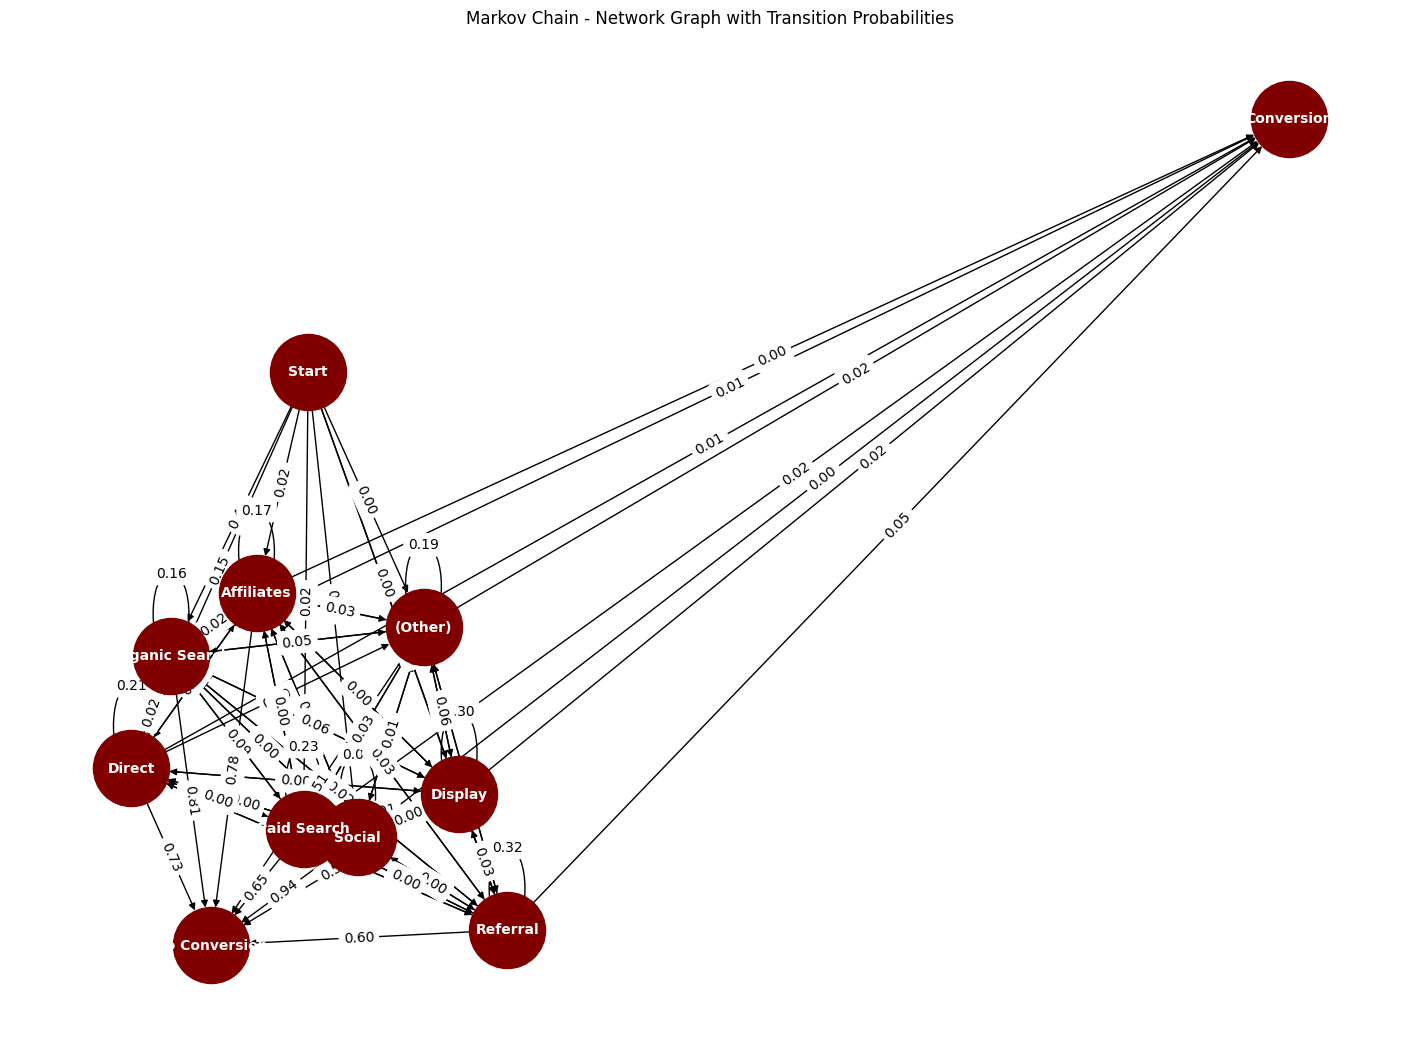

In [49]:
# Normalize transitions to get probabilities
normalized_transitions = {}
for from_channel in transitions:
    total = sum(transitions[from_channel].values())
    normalized_transitions[from_channel] = {to_channel: transitions[from_channel][to_channel] / total for to_channel in transitions[from_channel]}

# Create directed graph with normalized weights
G_prob = nx.DiGraph()
for from_channel in normalized_transitions:
    for to_channel in normalized_transitions[from_channel]:
        G_prob.add_edge(from_channel, to_channel, weight=normalized_transitions[from_channel][to_channel])

# Draw the network graph with probabilities
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_prob)
nx.draw(G_prob, pos, with_labels=True, node_size=3000, node_color='#800000', font_size=10, font_weight='bold', arrows=True, font_color='white')
edge_labels_prob = nx.get_edge_attributes(G_prob, 'weight')
edge_labels_prob = {k: f"{v:.2f}" for k, v in edge_labels_prob.items()}  # Format probabilities
nx.draw_networkx_edge_labels(G_prob, pos, edge_labels=edge_labels_prob)
plt.title('Markov Chain - Network Graph with Transition Probabilities')
plt.show()


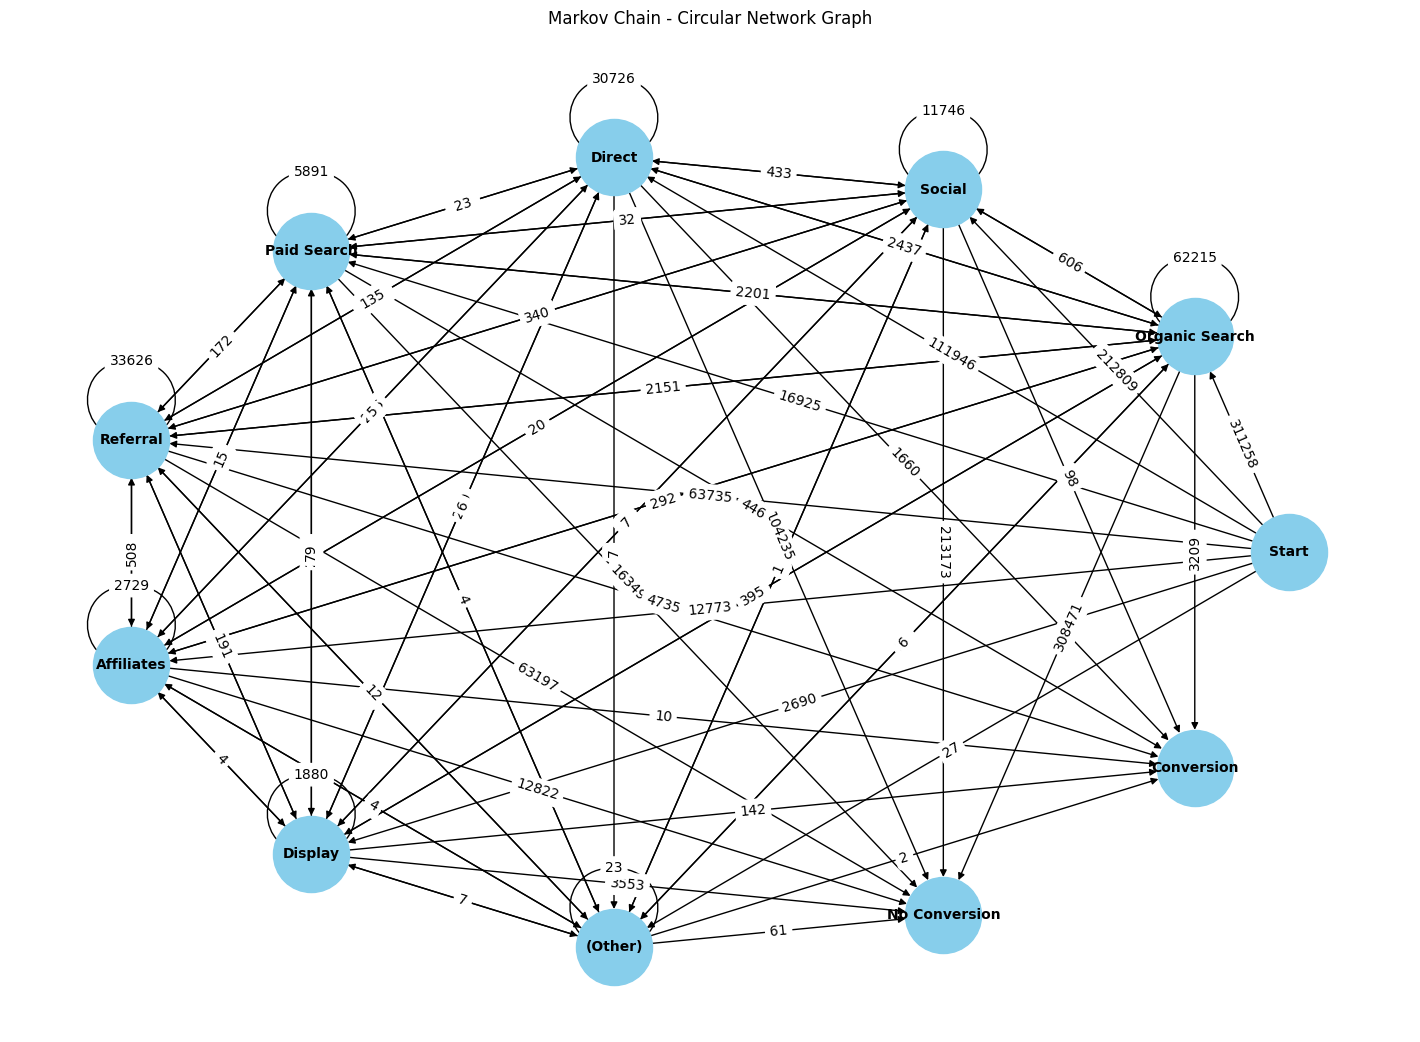

In [77]:
plt.figure(figsize=(14, 10))

# Circular layout for nodes
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Markov Chain - Circular Network Graph')
plt.show()

Circle Pack Diagram

In [79]:
import plotly.express as px
import pandas as pd

# Prepare data for Circle Pack Diagram
circle_pack_data = []

for from_channel in transitions:
    for to_channel in transitions[from_channel]:
        circle_pack_data.append({
            'parent': from_channel,
            'child': to_channel,
            'value': transitions[from_channel][to_channel]
        })

# Convert to DataFrame
df_circle_pack = pd.DataFrame(circle_pack_data)

# Since Circle Pack Diagrams are typically hierarchical, we create a root node
root = pd.DataFrame([{'parent': '', 'child': 'All Channels', 'value': df_circle_pack['value'].sum()}])
df_circle_pack = pd.concat([root, df_circle_pack], ignore_index=True)

# Create the Circle Pack Diagram
fig = px.treemap(df_circle_pack, path=['parent', 'child'], values='value', title='Markov Chain - Circle Pack Diagram')
fig.update_traces(root_color="lightgrey")
fig.show()


#Comparison

In [55]:
compare_df = comparison_summary.drop(['conversions', 'total_visits', 'conversion_rate'],axis = 1)

In [56]:
compare_df

,channel,LC Conversion Contribution,DDA Conversion Contribution
0,Referral,46.122449,38.440435
1,Organic Search,29.856709,8.414762
2,Direct,17.733391,8.233167
3,Paid Search,4.064264,11.720437
4,Display,1.233174,17.120138
5,Social,0.903170,0.339529
6,Affiliates,0.078159,1.578780
7,(Other),0.008684,14.152752


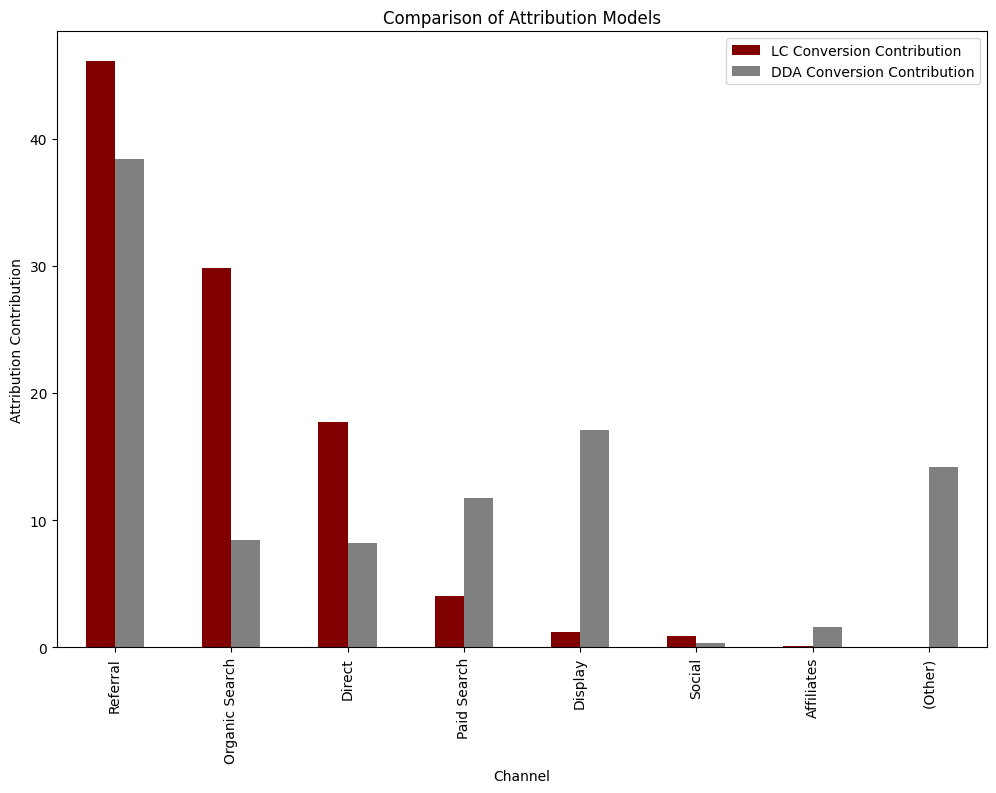

In [57]:
compare_df.set_index('channel', inplace=True)
compare_df.plot(kind='bar', figsize=(12, 8), color = ['#800000', 'gray'])
plt.title('Comparison of Attribution Models')
plt.ylabel('Attribution Contribution')
plt.xlabel('Channel')
plt.show()

Radar Chart (Spider Chart)

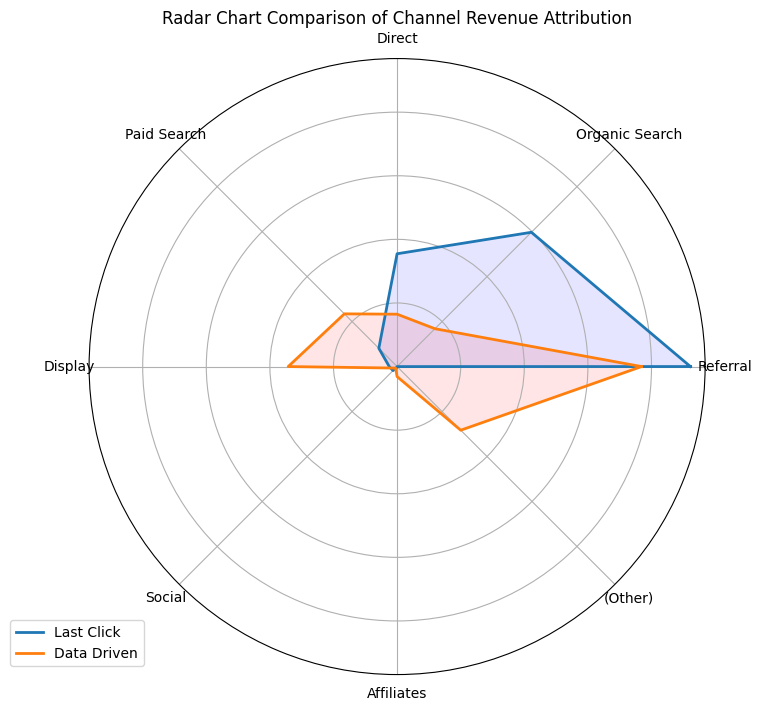

In [96]:
from math import pi

# Data preparation
categories = compare_df.index
last_click_values = compare_df['LC Conversion Contribution'].values
data_driven_values = compare_df['DDA Conversion Contribution'].values

# Number of variables
num_vars = len(categories)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Add the last values to close the circle
last_click_values = np.concatenate((last_click_values, [last_click_values[0]]))
data_driven_values = np.concatenate((data_driven_values, [data_driven_values[0]]))

# Plot data
ax.plot(angles, last_click_values, linewidth=2, linestyle='solid', label='Last Click')
ax.fill(angles, last_click_values, 'b', alpha=0.1)

ax.plot(angles, data_driven_values, linewidth=2, linestyle='solid', label='Data Driven')
ax.fill(angles, data_driven_values, 'r', alpha=0.1)

# Add labels and title
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Radar Chart Comparison of Channel Revenue Attribution')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()
